In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('/airquality.csv')

In [4]:
print(df.head())

  StationId        Date  PM2.5    PM10    NO    NO2    NOx    NH3    CO  \
0     AP001  24-11-2017  71.36  115.75  1.75  20.65  12.40  12.19  0.10   
1     AP001  25-11-2017  81.40  124.50  1.44  20.50  12.08  10.72  0.12   
2     AP001  26-11-2017  78.32  129.06  1.26  26.00  14.85  10.28  0.14   
3     AP001  27-11-2017  88.76  135.32  6.60  30.85  21.77  12.91  0.11   
4     AP001  28-11-2017  64.18  104.09  2.56  28.07  17.01  11.42  0.09   

     SO2      O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  
0  10.76  109.26     0.17     5.92    0.10    NaN        NaN  
1  15.24  127.09     0.20     6.50    0.06  184.0   Moderate  
2  26.96  117.44     0.22     7.95    0.08  197.0   Moderate  
3  33.59  111.81     0.29     7.63    0.12  198.0   Moderate  
4  19.00  138.18     0.17     5.02    0.07  188.0   Moderate  


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       86410 non-null   float64
 3   PM10        65329 non-null   float64
 4   NO          90929 non-null   float64
 5   NO2         91488 non-null   float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          95037 non-null   float64
 9   SO2         82831 non-null   float64
 10  O3          82467 non-null   float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         87025 non-null   float64
 15  AQI_Bucket  87025 non-null   object 
dtypes: float64(13), object(3)
memory usage: 13.2+ MB
None


In [6]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 StationId         0
Date              0
PM2.5         21625
PM10          42706
NO            17106
NO2           16547
NOx           15500
NH3           48105
CO            12998
SO2           25204
O3            25568
Benzene       31455
Toluene       38702
Xylene        85137
AQI           21010
AQI_Bucket    21010
dtype: int64


In [7]:
print("Shape:", df.shape)

Shape: (108035, 16)


In [8]:
numerical_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
                     'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']


In [9]:
for col in numerical_columns:
    df[col] = df[col].fillna(df[col].mean())

In [10]:
df['AQI_Bucket'] = df['AQI_Bucket'].fillna(df['AQI_Bucket'].mode()[0])

In [11]:
df.drop_duplicates(inplace=True)

In [13]:
# Get unique Station IDs
station_ids = df['StationId'].unique()

# Generate the same number of cities (mock values), repeating if needed
city_names = ['CityA', 'CityB', 'CityC', 'CityD']
city_list = (city_names * ((len(station_ids) // len(city_names)) + 1))[:len(station_ids)]

# Create the DataFrame
station_data = pd.DataFrame({
    'StationId': station_ids,
    'City': city_list
})

# Merge with main DataFrame
df = pd.merge(df, station_data, on='StationId', how='left')


In [14]:
# ========== 3. Data Transformation ==========

# Label encoding of AQI_Bucket
le = LabelEncoder()
df['AQI_Bucket'] = le.fit_transform(df['AQI_Bucket'])

In [15]:
# ========== 4. Error Correction ==========

# Remove outliers using IQR method
def remove_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return column.apply(lambda x: np.nan if x < lower or x > upper else x)

for col in numerical_columns:
    df[col] = remove_outliers(df[col])

In [16]:
for col in numerical_columns:
    df[col] = df[col].fillna(df[col].mean())

# Optional domain error correction
df = df[df['AQI'] >= 0]  # AQI cannot be negative

In [17]:
# ========== 5. Data Model Building ==========

# Define features and target
features = ['PM2.5', 'PM10', 'AQI_Bucket']
target = 'AQI'

X = df[features]
y = df[target]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
predictions = model.predict(X_test_scaled)

print("\nModel Evaluation:")
print("Mean Squared Error:", mean_squared_error(y_test, predictions))
print("R2 Score:", r2_score(y_test, predictions))



Model Evaluation:
Mean Squared Error: 2811.9515395967574
R2 Score: 0.58879795824581


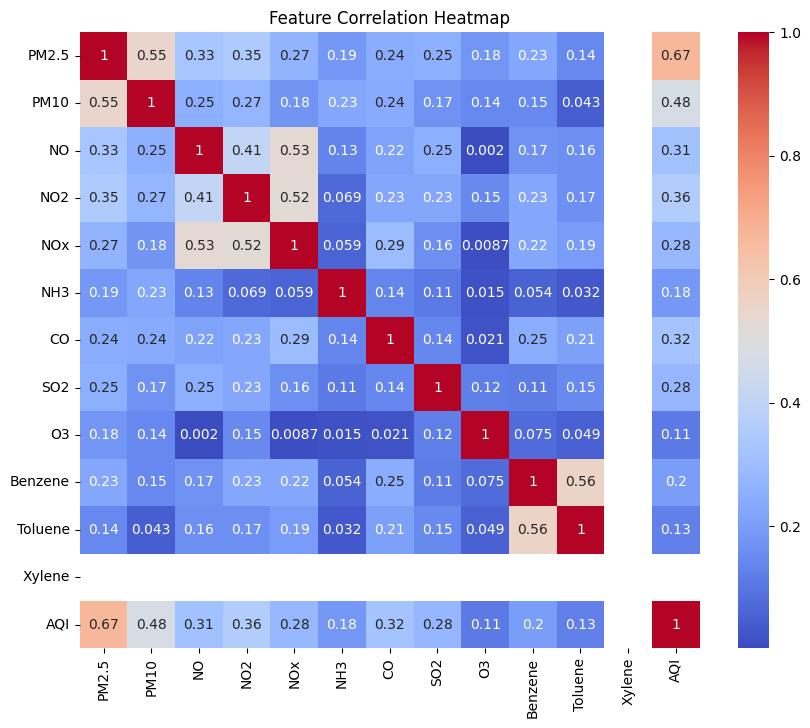

In [20]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


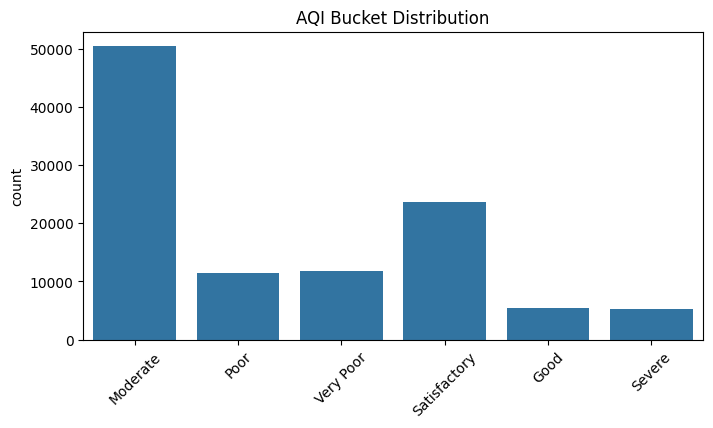

In [21]:
# Countplot for AQI_Bucket
plt.figure(figsize=(8, 4))
sns.countplot(x=le.inverse_transform(df['AQI_Bucket']))
plt.title("AQI Bucket Distribution")
plt.xticks(rotation=45)
plt.show()